# Imports

In [11]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [12]:
# Mapping for recognized traffic signs
def classify_sign(orb_match_result):
    """Maps ORB matching results to actual traffic sign names."""
    sign_labels = {
        "0": "Speed limit (20km/h)", "1": "Speed limit (30km/h)", "2": "Speed limit (50km/h)",
        "3": "Speed limit (60km/h)", "4": "Speed limit (70km/h)", "5": "Speed limit (80km/h)",
        "6": "End of speed limit (80km/h)", "7": "Speed limit (100km/h)", "8": "Speed limit (120km/h)",
        "9": "No passing", "10": "No passing for vehicles over 3.5 tons", "11": "Right-of-way at intersection",
        "12": "Priority road", "13": "Yield", "14": "Stop", "15": "No vehicles",
        "16": "Vehicles > 3.5 tons prohibited", "17": "No entry", "18": "General caution",
        "19": "Dangerous curve left", "20": "Dangerous curve right", "21": "Double curve",
        "22": "Bumpy road", "23": "Slippery road", "24": "Road narrows on the right",
        "25": "Road work", "26": "Traffic signals", "27": "Pedestrians", "28": "Children crossing",
        "29": "Bicycles crossing", "30": "Beware of ice/snow", "31": "Wild animals crossing",
        "32": "End speed + passing limits", "33": "Turn right ahead", "34": "Turn left ahead",
        "35": "Ahead only", "36": "Go straight or right", "37": "Go straight or left",
        "38": "Keep right", "39": "Keep left", "40": "Roundabout mandatory",
        "41": "End of no passing", "42": "End no passing for vehicles > 3.5 tons"
    }
    return sign_labels.get(orb_match_result, "Unknown Traffic Sign")

In [13]:
# Function to Load and Preprocess Images
def preprocess_image(image_path):
    """Loads an image, converts it to HSV, applies Gaussian blur, and performs Canny edge detection."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image {image_path}")
    image = cv2.resize(image, (50, 50))  # Standardized size
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    blurred = cv2.GaussianBlur(hsv, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return image, gray, edges

In [14]:
# Function to Detect Shapes in Images
def detect_shapes(gray, edges):
    """Detects road sign shapes (circles, triangles, rectangles) using contour analysis."""
    shapes = []
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 0.01 * gray.shape[0] * gray.shape[1]:  # Dynamic threshold
            continue
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 3:
            shapes.append("Triangle (Warning Sign)")
        elif len(approx) == 4:
            shapes.append("Rectangle (Information Sign)")
        elif len(approx) > 5:
            shapes.append("Circle (Prohibitory Sign)")
    return shapes

In [15]:
# Function to Extract ORB Features
def extract_ORB_features(image):
    """Extracts ORB keypoints and descriptors from an image."""
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors



In [16]:
# Load Reference Images and Extract ORB Features
def load_reference_features(reference_folder):
    ref_features = {}
    orb = cv2.ORB_create()
    for file in os.listdir(reference_folder):
        file_path = os.path.join(reference_folder, file)
        ref_image = cv2.imread(file_path)
        if ref_image is None:
            continue
        ref_gray = cv2.cvtColor(ref_image, cv2.COLOR_BGR2GRAY)
        _, descriptors = orb.detectAndCompute(ref_gray, None)
        sign_name = os.path.splitext(file)[0]
        ref_features[sign_name] = descriptors
    return ref_features

In [17]:
# Recognizing Signs using ORB Feature Matching
def recognize_sign(test_image_gray, ref_features):
    orb = cv2.ORB_create()
    _, test_des = orb.detectAndCompute(test_image_gray, None)
    if test_des is None:
        return "Unknown"
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    best_match_count = 0
    recognized_sign = "Unknown"
    for sign_name, ref_des in ref_features.items():
        if ref_des is None:
            continue
        matches = bf.match(test_des, ref_des)
        good_matches = [m for m in matches if m.distance < 60]
        if len(good_matches) > best_match_count:
            best_match_count = len(good_matches)
            recognized_sign = sign_name
    if best_match_count < 10:
        recognized_sign = "Unknown"
    return classify_sign(recognized_sign)

In [23]:
def process_test_images(test_folder, reference_folder):
    # Load reference features from the specified folder
    ref_features = load_reference_features(reference_folder)
    results = []
    # Iterate through the files in the test folder
    for file in os.listdir(test_folder):
        file_path = os.path.join(test_folder, file)
        try:
            # Preprocess image and extract the grayscale image
            image, gray, edges = preprocess_image(file_path)
        except Exception as e:
            # Skip files that cannot be processed
            continue
    # Recognize the sign from the grayscale image using reference features
    recognized = recognize_sign(gray, ref_features)
    # Append a tuple with the filename, image path, and recognized label
    results.append((file, file_path, recognized))
    return results

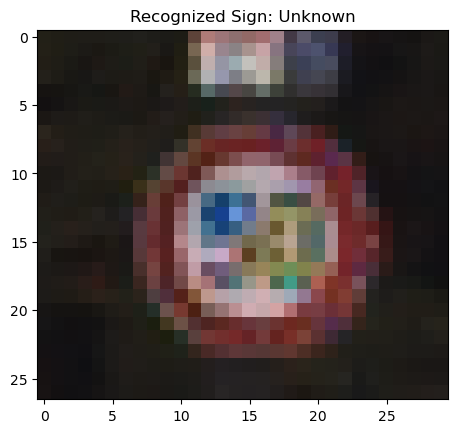

In [30]:
# Running the Pipeline on Sample Images
test_folder = "gtsrb-german-traffic-sign/Test"
reference_folder = "gtsrb-german-traffic-sign/Meta"
results = process_test_images(test_folder, reference_folder)

# Displaying Results for First Image
if results:
    test_image_path = os.path.join(test_folder, results[0][0])
    img = cv2.imread(test_image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Recognized Sign: {results[0][2]}")
    plt.show()